In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
# Load and prepare data
data = pd.read_csv("./data/BTC-USD.csv", index_col="Date", parse_dates=True)
data["Close"] = pd.to_numeric(data["Close"].replace(",","", regex=True))

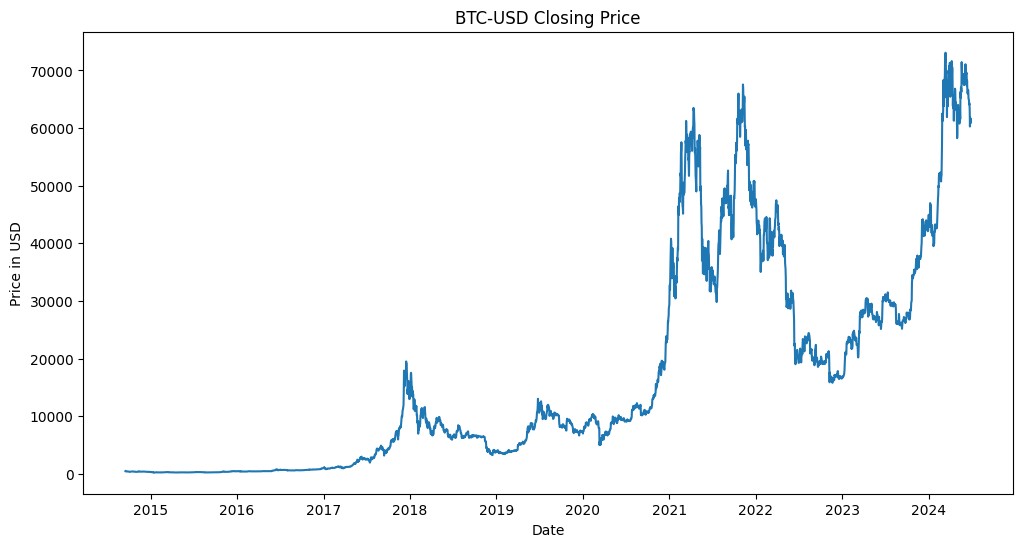

In [3]:
# Plot original data
plt.figure(figsize=(12,6))
plt.plot(data["Close"])
plt.title("BTC-USD Closing Price")
plt.xlabel("Date")
plt.ylabel("Price in USD")
plt.show()

In [4]:
# Difference the data
diff_data = data["Close"].diff().dropna()

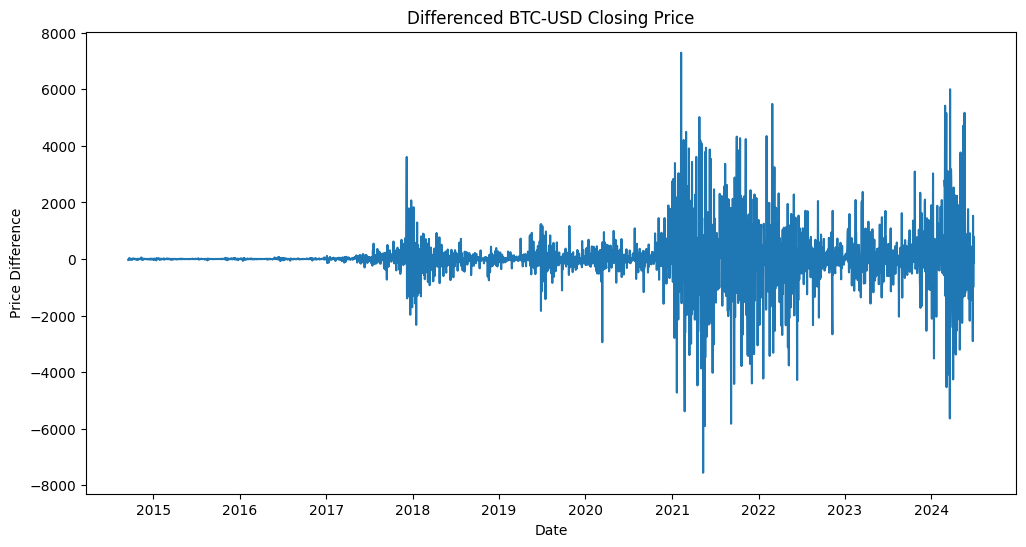

In [5]:
# Plot differenced data
plt.figure(figsize=(12,6))
plt.plot(diff_data)
plt.title("Differenced BTC-USD Closing Price")
plt.xlabel("Date")
plt.ylabel("Price Difference")
plt.show()

In [6]:
# Split data into train and test sets
train_data, test_data = diff_data[:int(len(diff_data)*0.9)], diff_data[int(len(diff_data)*0.9):]

In [7]:
# Auto ARIMA to find the best parameters
model_autoARIMA = auto_arima(train_data, start_p=1, start_q=1,
                             test='adf',
                             max_p=5, max_q=5,
                             m=7,  # Weekly seasonality
                             d=None,
                             seasonal=True,
                             start_P=0, 
                             D=1, 
                             trace=True,
                             error_action='ignore',  
                             suppress_warnings=True, 
                             stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[7] intercept   : AIC=inf, Time=5.09 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=54244.991, Time=0.23 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=53244.916, Time=5.57 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=inf, Time=6.59 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=54242.999, Time=0.21 sec
 ARIMA(1,0,0)(0,1,0)[7] intercept   : AIC=54246.122, Time=0.42 sec
 ARIMA(1,0,0)(2,1,0)[7] intercept   : AIC=52878.625, Time=9.74 sec
 ARIMA(1,0,0)(2,1,1)[7] intercept   : AIC=inf, Time=27.67 sec
 ARIMA(1,0,0)(1,1,1)[7] intercept   : AIC=inf, Time=7.19 sec
 ARIMA(0,0,0)(2,1,0)[7] intercept   : AIC=52882.855, Time=7.86 sec
 ARIMA(2,0,0)(2,1,0)[7] intercept   : AIC=52875.510, Time=25.81 sec
 ARIMA(2,0,0)(1,1,0)[7] intercept   : AIC=53245.017, Time=10.70 sec
 ARIMA(2,0,0)(2,1,1)[7] intercept   : AIC=inf, Time=21.36 sec
 ARIMA(2,0,0)(1,1,1)[7] intercept   : AIC=inf, Time=6.42 sec
 ARIMA(3,0,0)(2,1,0)[7] intercept   : AIC=52877.505

In [8]:
print(model_autoARIMA.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 3214
Model:             SARIMAX(2, 0, 0)x(2, 1, 0, 7)   Log Likelihood              -26431.755
Date:                           Mon, 05 Aug 2024   AIC                          52873.511
Time:                                   10:46:48   BIC                          52903.876
Sample:                               09-18-2014   HQIC                         52884.396
                                    - 07-06-2023                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0425      0.009     -5.004      0.000      -0.059      -0.026
ar.L2          0.0404      0.009      4.711

In [9]:
# Get the order and seasonal order from the auto_arima model
order = model_autoARIMA.order
seasonal_order = model_autoARIMA.seasonal_order
print(f"Best SARIMAX order: {order}")
print(f"Best SARIMAX seasonal order: {seasonal_order}")

Best SARIMAX order: (2, 0, 0)
Best SARIMAX seasonal order: (2, 1, 0, 7)


In [10]:
# Build SARIMAX model with the best order
model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order)
results = model.fit()
print(results.summary())

c:\Users\HomePC\Documents\finance_ml\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\HomePC\Documents\finance_ml\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                             Close   No. Observations:                 3214
Model:             SARIMAX(2, 0, 0)x(2, 1, 0, 7)   Log Likelihood              -26431.755
Date:                           Mon, 05 Aug 2024   AIC                          52873.511
Time:                                   10:47:00   BIC                          52903.876
Sample:                               09-18-2014   HQIC                         52884.396
                                    - 07-06-2023                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0425      0.009     -5.004      0.000      -0.059      -0.026
ar.L2          0.0404      0.009      4.711

In [11]:
# Forecast
fc = results.get_forecast(steps=len(test_data))
fc_mean = fc.predicted_mean

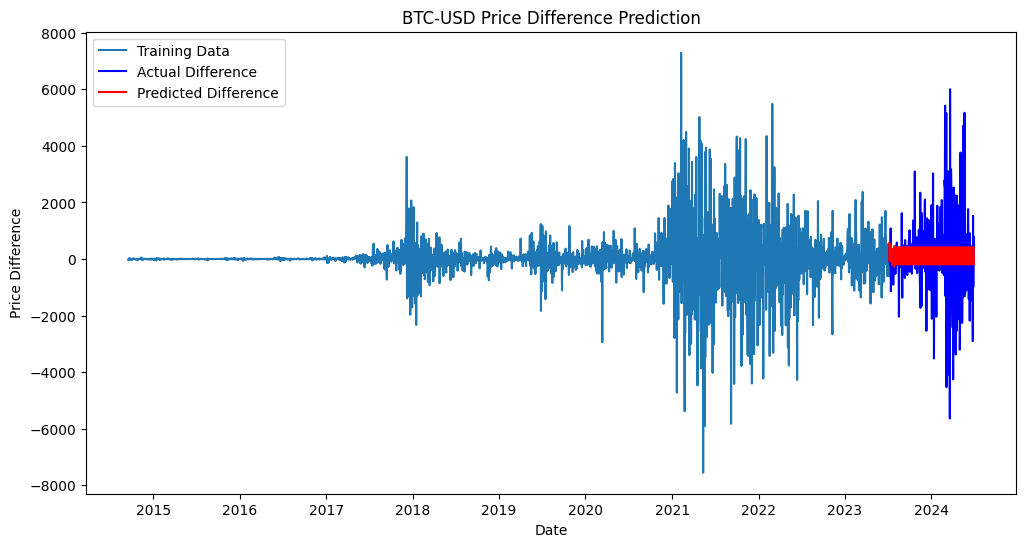

In [12]:
# Plot the forecast (differenced data)
plt.figure(figsize=(12,6))
plt.plot(train_data.index, train_data, label='Training Data')
plt.plot(test_data.index, test_data, color='blue', label='Actual Difference')
plt.plot(test_data.index, fc_mean, color='red', label='Predicted Difference')
plt.title('BTC-USD Price Difference Prediction')
plt.xlabel('Date')
plt.ylabel('Price Difference')
plt.legend(loc='upper left')
plt.show()

In [13]:
# Cumulative sum to get back to original scale
fc_cumsum = fc_mean.cumsum()
actual_cumsum = test_data.cumsum()

In [14]:
# Add the last training data point to get back to the original scale
last_train_value = data['Close'].iloc[len(train_data)]
fc_forecast = last_train_value + fc_cumsum
actual_forecast = last_train_value + actual_cumsum

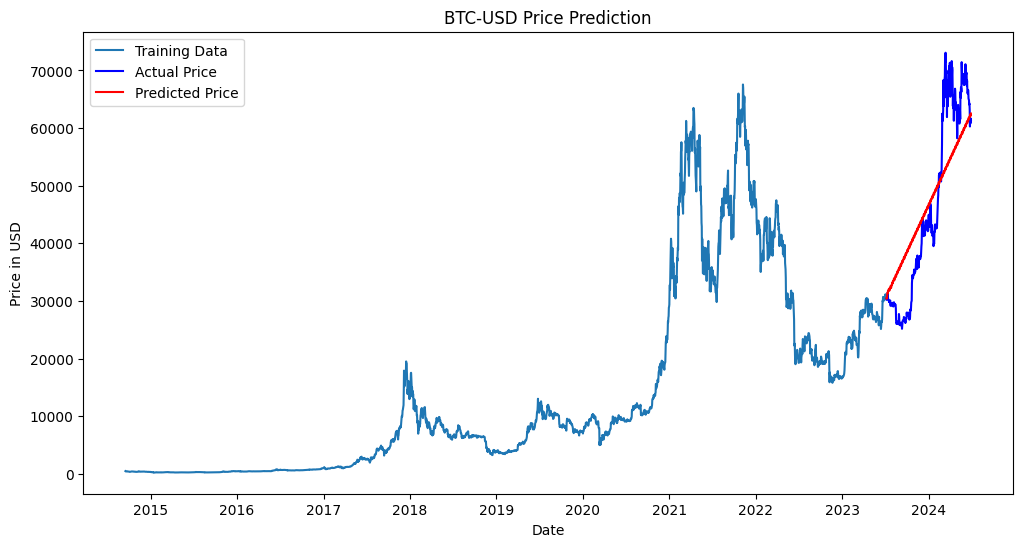

In [15]:
# Plot the forecast in original scale
plt.figure(figsize=(12,6))
plt.plot(data['Close'][:len(train_data)], label='Training Data')
plt.plot(actual_forecast.index, actual_forecast, color='blue', label='Actual Price')
plt.plot(fc_forecast.index, fc_forecast, color='red', label='Predicted Price')
plt.title('BTC-USD Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.legend(loc='upper left')
plt.show()

In [16]:
# Evaluate model performance
mse = mean_squared_error(actual_forecast, fc_forecast)
mae = mean_absolute_error(actual_forecast, fc_forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((actual_forecast - fc_forecast) / actual_forecast)) * 100

In [17]:
print('Mean Squared Error (MSE): {:.3f}'.format(mse))
print('Mean Absolute Error (MAE): {:.3f}'.format(mae))
print('Root Mean Squared Error (RMSE): {:.3f}'.format(rmse))
print('Mean Absolute Percentage Error (MAPE): {:.3f}%'.format(mape))

Mean Squared Error (MSE): 67122184.557
Mean Absolute Error (MAE): 6982.031
Root Mean Squared Error (RMSE): 8192.813
Mean Absolute Percentage Error (MAPE): 17.037%
